# Solar Tracking: Measuring the Sun's Differential Rotation

This notebook demonstrates the complete workflow of the `solar_tracking` package for:
1. **Downloading** HMI solar images from the Solar Dynamics Observatory
2. **Detecting** sunspots using computer vision techniques
3. **Tracking** sunspot motion across image sequences
4. **Calculating** heliographic coordinates and rotation rates
5. **Fitting** the differential rotation model

## Scientific Background

The Sun exhibits **differential rotation** - it doesn't rotate as a rigid body. The equator completes a rotation in about 25 days, while regions near the poles take about 35 days. This rotation profile follows:

$$\Omega(B) = A + B \cdot \sin^2(B)$$

where $\Omega$ is the angular velocity and $B$ is the heliographic latitude.

## 1. Setup and Imports

In [1]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Astronomy libraries
import sunpy.map
import astropy.units as u
import warnings
warnings.filterwarnings("ignore", module="astropy")

# Computer vision
import cv2

# Solar tracking package
from solar_tracking.downloader import download_fits
from solar_tracking.image_processing import image_processing_fits
from solar_tracking.sunspot_detection import sun_infos, find_spots_and_boxes
from solar_tracking.rotation_analysis import cal_lon_and_lat, cal_omega_p
from solar_tracking.fitting import fit_func, perform_fitting
from solar_tracking.plotting import plot_results

# Display settings
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['figure.dpi'] = 100

## 2. Downloading Solar Data

The package can automatically download HMI continuum intensity images from the Virtual Solar Observatory. These images show the Sun's photosphere where sunspots are visible as dark regions.

**Note:** This cell is commented out as data is already available in `data/TR_XX/` folders.

In [2]:
# Uncomment to download new data
# downloaded_files = download_fits(
#     start_time="2023-11-23 00:00:00",
#     end_time="2023-11-25 00:00:00",
#     instrument="hmi",
#     sample=1  # One image per hour
# )
# print(f"Downloaded {len(downloaded_files)} files")

## 3. Loading and Visualizing Solar Images

Let's load a sample FITS file and examine the solar disk. The HMI instrument provides 4096x4096 pixel images of the Sun.

In [3]:
# Define path to sample data
trace = 1
data_path = Path(f"data/TR_0{trace}")

# Load file list
names_file = data_path / "names.txt"
file_paths = np.genfromtxt(str(names_file), dtype=str)
print(f"Found {len(file_paths)} FITS files in trace {trace}")
print(f"First file: {file_paths[0]}")
print(f"Last file: {file_paths[-1]}")

Found 72 FITS files in trace 1
First file: hmi_ic_45s_2023_11_23_00_01_30_tai_continuum.fits
Last file: hmi_ic_45s_2023_11_25_23_01_30_tai_continuum.fits


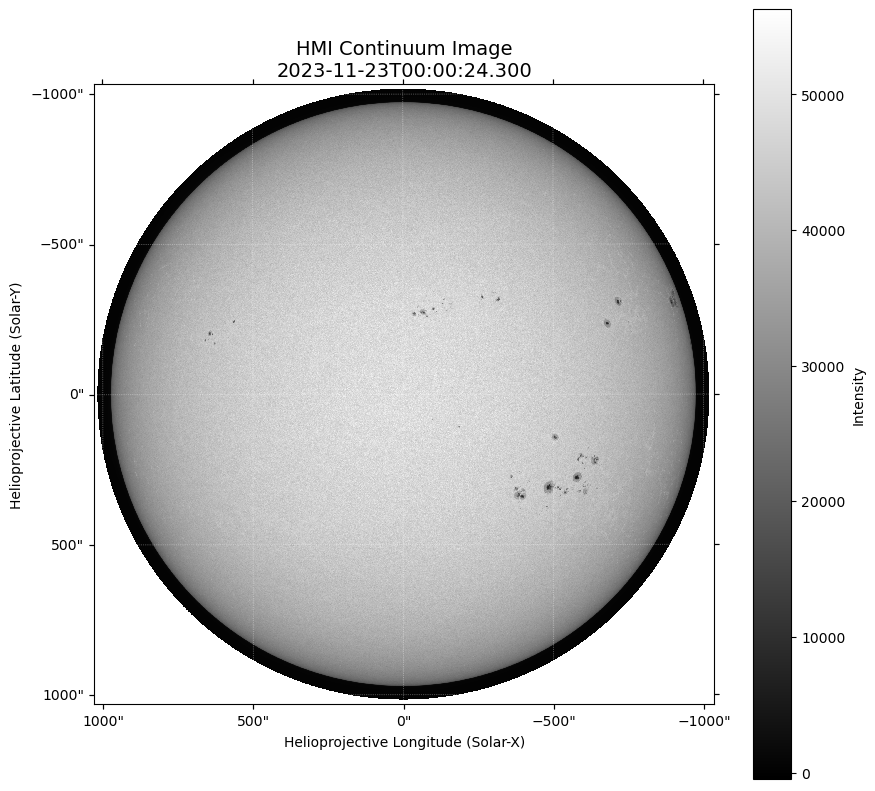


Image metadata:
  Date: 2023-11-23T00:00:24.300
  Instrument: HMI FRONT2
  Dimensions: PixelPair(x=<Quantity 4096. pix>, y=<Quantity 4096. pix>)
  Scale: SpatialPair(axis1=<Quantity 0.504033 arcsec / pix>, axis2=<Quantity 0.504033 arcsec / pix>)


In [4]:
# Load first image using SunPy
first_file = data_path / file_paths[0]
smap = sunpy.map.Map(str(first_file))

# Display solar image
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=smap)
smap.plot(axes=ax)
ax.set_title(f"HMI Continuum Image\n{smap.date}", fontsize=14)
plt.colorbar(label='Intensity')
plt.show()

# Print metadata
print(f"\nImage metadata:")
print(f"  Date: {smap.date}")
print(f"  Instrument: {smap.instrument}")
print(f"  Dimensions: {smap.dimensions}")
print(f"  Scale: {smap.scale}")

## 4. Image Preprocessing

Before detecting sunspots, we normalize the image to enhance contrast. The `image_processing_fits` function:
1. Extracts the data layer from the FITS file
2. Normalizes pixel values to 0-255 range
3. Converts to 8-bit format for OpenCV processing

Sun radius: 1927 pixels
Sun center: (2041, 2047)
Image resolution: 4096 x 4096


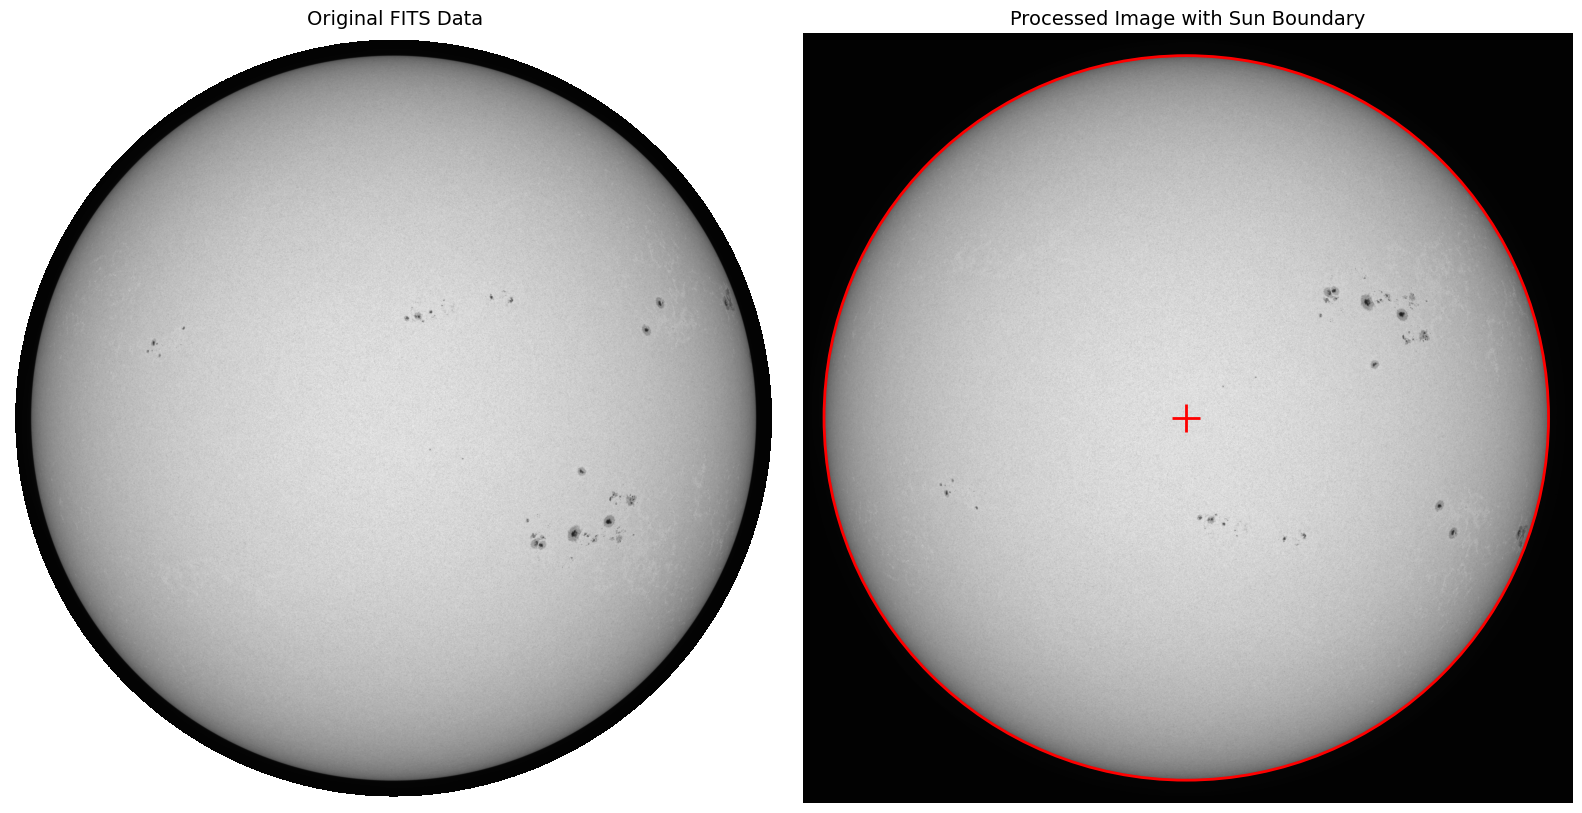

In [5]:
# Process the FITS file
processed_image = image_processing_fits(str(first_file))

# Get sun information from FITS header
sun_radius, sun_center, resolution = sun_infos(str(first_file))

print(f"Sun radius: {sun_radius} pixels")
print(f"Sun center: {sun_center}")
print(f"Image resolution: {resolution} x {resolution}")

# Display processed image
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Original
axes[0].imshow(smap.data, cmap='gray', origin='lower')
axes[0].set_title('Original FITS Data', fontsize=14)
axes[0].axis('off')

# Processed
axes[1].imshow(processed_image, cmap='gray')
circle = plt.Circle(sun_center, sun_radius, fill=False, color='red', linewidth=2)
axes[1].add_patch(circle)
axes[1].plot(*sun_center, 'r+', markersize=20, markeredgewidth=2)
axes[1].set_title('Processed Image with Sun Boundary', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 5. Sunspot Detection

Sunspots appear as dark regions on the solar disk. The detection algorithm:
1. Applies Gaussian blur to reduce noise
2. Uses adaptive thresholding to create a binary mask
3. Finds connected components (potential spots)
4. Filters by area and distance from sun center
5. Groups nearby spots using DBSCAN clustering

Detected 7 sunspot groups


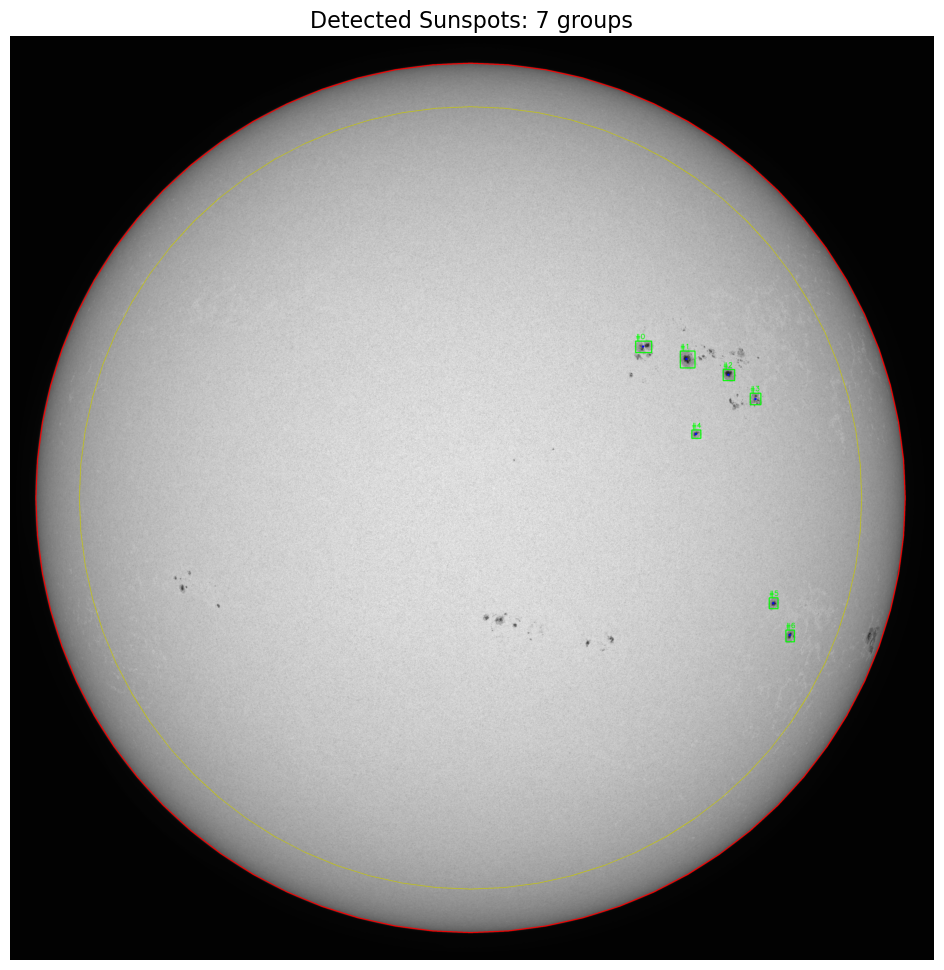


Spot details:
  Spot #0: position=(2806.9, 1376.9), size=71x51 px
  Spot #1: position=(2998.2, 1431.6), size=65x75 px
  Spot #2: position=(3184.8, 1501.8), size=51x49 px
  Spot #3: position=(3304.2, 1609.9), size=47x51 px
  Spot #4: position=(3040.3, 1764.0), size=40x37 px
  Spot #5: position=(3383.3, 2514.1), size=39x48 px
  Spot #6: position=(3456.3, 2655.7), size=38x52 px


In [6]:
# Detect sunspots
bounding_boxes, centroids = find_spots_and_boxes(
    processed_image, 
    sun_radius, 
    sun_center,
    max_area=5000,
    min_area=1000,
    max_distance_ratio=0.9
)

print(f"Detected {len(bounding_boxes)} sunspot groups")

# Visualize detections
fig, ax = plt.subplots(figsize=(12, 12))
display_img = cv2.cvtColor(processed_image, cv2.COLOR_GRAY2RGB)

# Draw sun boundary
cv2.circle(display_img, sun_center, sun_radius, (255, 0, 0), 3)
cv2.circle(display_img, sun_center, int(sun_radius * 0.9), (200, 200, 0), 2)

# Draw detected spots
for idx, (box, centroid) in enumerate(zip(bounding_boxes, centroids)):
    x, y, w, h = box
    # Bounding box
    cv2.rectangle(display_img, (x, y), (x+w, y+h), (0, 255, 0), 3)
    # Centroid
    cx, cy = int(centroid[0]), int(centroid[1])
    cv2.circle(display_img, (cx, cy), 5, (0, 0, 255), -1)
    # Label
    cv2.putText(display_img, f"#{idx}", (x, y-10), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

ax.imshow(display_img)
ax.set_title(f'Detected Sunspots: {len(bounding_boxes)} groups', fontsize=16)
ax.axis('off')
plt.show()

# Print spot details
print("\nSpot details:")
for idx, (box, centroid) in enumerate(zip(bounding_boxes, centroids)):
    print(f"  Spot #{idx}: position=({centroid[0]:.1f}, {centroid[1]:.1f}), size={box[2]}x{box[3]} px")

## 6. Sunspot Tracking

The interactive tracking uses OpenCV's MIL tracker to follow sunspots across the image sequence. 

**Note:** Interactive tracking requires a GUI window and is best run from the command line:
```bash
solar-tracking run_tracking --trace 1
```

Here we demonstrate loading pre-computed tracking results from `data_points.csv`.

In [7]:
# Load tracking results
data_file = data_path / "data_points.csv"

if data_file.exists():
    tracking_data = np.genfromtxt(str(data_file), delimiter=',', skip_header=1)
    
    if tracking_data.ndim == 1:
        tracking_data = tracking_data.reshape(1, -1)
    
    print(f"Loaded {len(tracking_data)} tracked sunspots")
    print("\nColumns: x1, y1, x2, y2, delta_time [hours]")
    print(tracking_data)
else:
    print("No tracking data found. Run interactive tracking first:")
    print("  solar-tracking run_tracking --trace 1")
    tracking_data = None

Loaded 6 tracked sunspots

Columns: x1, y1, x2, y2, delta_time [hours]
[[2806.  1376.  1633.5 1361.5   71. ]
 [3184.  1501.  1985.5 1496.5   71. ]
 [3304.  1609.  2148.5 1599.5   71. ]
 [3040.  1764.  1771.  1747.5   71. ]
 [3383.  2514.  2228.5 2523.    71. ]
 [3456.  2655.  2394.  2661.    71. ]]


## 7. Coordinate Conversion

To calculate rotation rates, we need to convert pixel coordinates to heliographic coordinates (latitude and longitude on the Sun's surface). This uses the World Coordinate System (WCS) information in the FITS headers.

In [8]:
if tracking_data is not None and len(tracking_data) > 0:
    # Load maps for coordinate conversion
    first_map = sunpy.map.Map(str(data_path / file_paths[0]))
    last_map = sunpy.map.Map(str(data_path / file_paths[-1]))
    
    latitudes = []
    omega_values = []
    
    print("Heliographic coordinates for tracked spots:\n")
    print(f"{'Spot':<6} {'Start (lon, lat)':<25} {'End (lon, lat)':<25} {'Omega [°/day]':<15}")
    print("-" * 75)
    
    for i, row in enumerate(tracking_data):
        x1, y1, x2, y2, delta_t = row
        
        # Convert to heliographic coordinates
        coord1 = cal_lon_and_lat(x1, y1, first_map)
        coord2 = cal_lon_and_lat(x2, y2, last_map)
        
        # Calculate rotation rate
        omega, period = cal_omega_p(coord1, coord2, delta_t)
        
        lat = coord1.lat.deg
        latitudes.append(lat)
        omega_values.append(omega.value)
        
        print(f"{i:<6} ({coord1.lon.deg:>7.2f}°, {coord1.lat.deg:>6.2f}°)   "
              f"({coord2.lon.deg:>7.2f}°, {coord2.lat.deg:>6.2f}°)   "
              f"{omega.value:>8.2f}")
    
    latitudes = np.array(latitudes)
    omega_values = np.array(omega_values)
else:
    print("No tracking data available for coordinate conversion.")

Heliographic coordinates for tracked spots:

Spot   Start (lon, lat)          End (lon, lat)            Omega [°/day]  
---------------------------------------------------------------------------
0      ( 356.01°,  22.07°)   ( 355.39°,  22.24°)      12.82
1      ( 342.86°,  17.96°)   ( 343.98°,  18.08°)      13.72
2      ( 338.82°,  14.57°)   ( 338.96°,  14.93°)      13.65
3      ( 349.62°,  10.10°)   ( 350.39°,  10.44°)      14.12
4      ( 335.89°, -12.56°)   ( 336.53°, -12.64°)      13.94
5      ( 331.23°, -17.03°)   ( 331.23°, -16.92°)      13.44


## 8. Differential Rotation Fitting

Now we fit the observed rotation rates to the differential rotation model:

$$\Omega(B) = A + B \cdot \sin^2(B)$$

The parameter $A$ represents the equatorial rotation rate, and $B$ describes how much the rotation slows toward the poles.

In [9]:
if tracking_data is not None and len(tracking_data) > 2:
    # Perform curve fitting
    popt, r_squared = perform_fitting(latitudes, omega_values)
    
    print("Differential Rotation Fit Results:")
    print(f"  A (equatorial rate): {popt[0]:.3f} °/day")
    print(f"  B (latitude term):   {popt[1]:.3f} °/day")
    print(f"  R² (goodness of fit): {r_squared:.4f}")
    print(f"\n  Equatorial period: {360/popt[0]:.1f} days")
else:
    print("Need at least 3 data points for fitting.")
    # Use example values for demonstration
    print("\nUsing example parameters for demonstration:")
    popt = np.array([14.5, -2.5])  # Typical solar values
    latitudes = np.array([5, 10, 15, 20, 25, -8, -15])
    omega_values = fit_func(latitudes, *popt) + np.random.normal(0, 0.3, len(latitudes))
    r_squared = 0.85

Differential Rotation Fit Results:
  A (equatorial rate): 14.453 °/day
  B (latitude term):   -10.845 °/day
  R² (goodness of fit): 0.8806

  Equatorial period: 24.9 days


## 9. Results Visualization

Finally, we visualize the differential rotation curve showing how the Sun's rotation period varies with latitude.

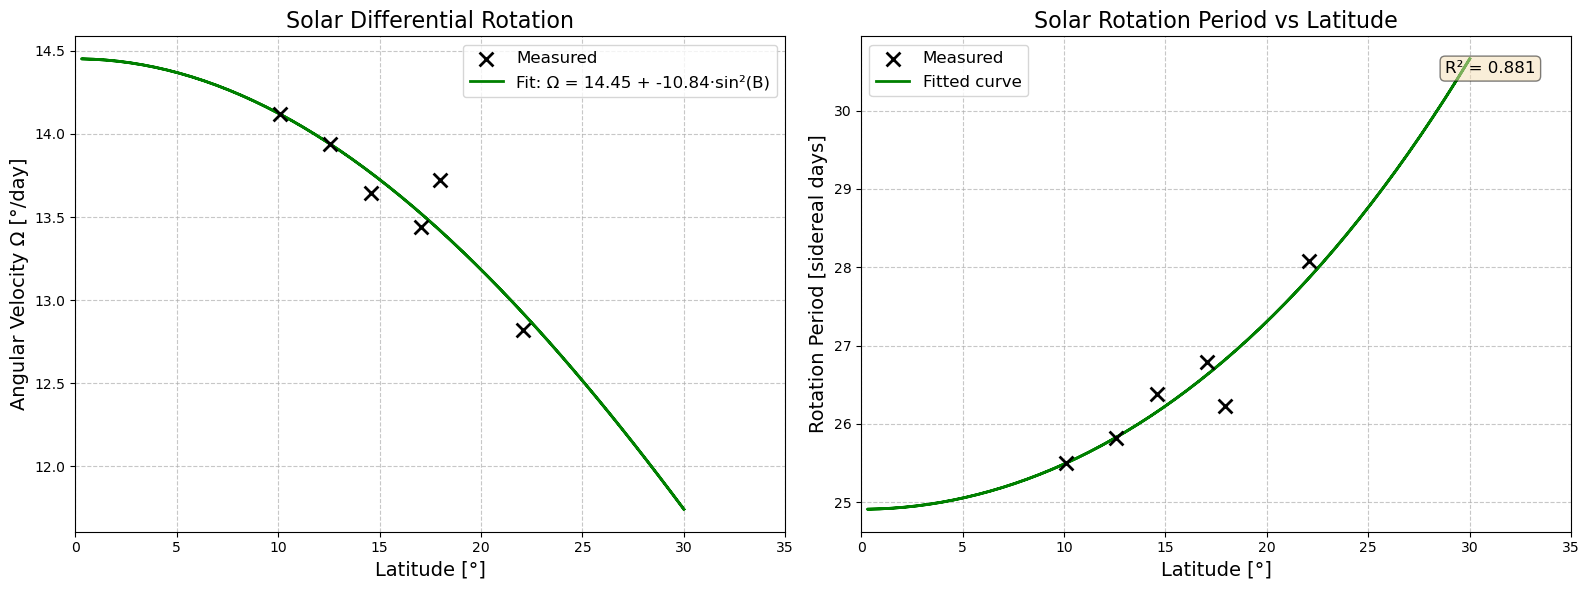


Results saved to 'differential_rotation_results.png'


In [10]:
# Create latitude range for fitted curve
lat_range = np.linspace(-30, 30, 100)
omega_fit = fit_func(lat_range, *popt)
period_fit = 360 / omega_fit  # Convert to period in days

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Angular velocity vs latitude
ax1 = axes[0]
ax1.scatter(np.abs(latitudes), omega_values, s=100, c='black', marker='x', 
            linewidths=2, label='Measured', zorder=5)
ax1.plot(np.abs(lat_range), omega_fit, 'g-', linewidth=2, 
         label=f'Fit: Ω = {popt[0]:.2f} + {popt[1]:.2f}·sin²(B)')
ax1.set_xlabel('Latitude [°]', fontsize=14)
ax1.set_ylabel('Angular Velocity Ω [°/day]', fontsize=14)
ax1.set_title('Solar Differential Rotation', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xlim(0, 35)

# Right: Rotation period vs latitude
ax2 = axes[1]
ax2.scatter(np.abs(latitudes), 360/omega_values, s=100, c='black', marker='x',
            linewidths=2, label='Measured', zorder=5)
ax2.plot(np.abs(lat_range), period_fit, 'g-', linewidth=2, label='Fitted curve')
ax2.set_xlabel('Latitude [°]', fontsize=14)
ax2.set_ylabel('Rotation Period [sidereal days]', fontsize=14)
ax2.set_title('Solar Rotation Period vs Latitude', fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xlim(0, 35)

# Add annotation
ax2.annotate(f'R² = {r_squared:.3f}', xy=(0.95, 0.95), xycoords='axes fraction',
             fontsize=12, ha='right', va='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('differential_rotation_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nResults saved to 'differential_rotation_results.png'")

## 10. Summary

This notebook demonstrated the complete workflow for measuring solar differential rotation:

| Step | Function | Description |
|------|----------|-------------|
| 1 | `download_fits()` | Download HMI data from VSO |
| 2 | `image_processing_fits()` | Preprocess FITS images |
| 3 | `sun_infos()` | Extract sun parameters from headers |
| 4 | `find_spots_and_boxes()` | Detect sunspots using CV |
| 5 | `run_tracking()` | Track spots interactively |
| 6 | `cal_lon_and_lat()` | Convert to heliographic coords |
| 7 | `cal_omega_p()` | Calculate rotation rates |
| 8 | `perform_fitting()` | Fit differential rotation model |
| 9 | `plot_results()` | Visualize results |

### Key Results

The differential rotation profile $\Omega(B) = A + B \cdot \sin^2(B)$ shows that:
- The equator rotates fastest (period ≈ 25 days)
- Rotation slows toward higher latitudes
- This confirms the Sun is not a rigid body

### Further Reading

- [SDO/HMI Instrument](http://hmi.stanford.edu/)
- [SunPy Documentation](https://docs.sunpy.org/)
- [Solar Differential Rotation (Wikipedia)](https://en.wikipedia.org/wiki/Solar_rotation)